## **Import potřebných knihoven a určení barevného spektra**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import json
import csv
from scipy.stats import shapiro
import datetime as dt
import statisti

In [2]:
import seaborn as sns
sns.set(style="ticks")
sns.set_color_codes("colorblind")
sns.set(style="darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# urceni barev
color = [
'#000000',
'#000080',
'#0B0BFF',
'#98B5FF', 
'#BBC9DB',
'#797975',
'#0198E1',
'#00688B',
'#74CDDC', #nej
'#05EDFF',  
'#C9FFFF', 
'#8FBCBC',
'#457371',
'#28AE7B',
'#4DFFA5'
]

## **Načtení souborů, úprava sloupečků, datových typů a rozdělení data setu na 2 období**

In [5]:
soubor = pd.read_csv('final.csv', encoding='utf-8', low_memory=False)

#### Změna datového typu

In [6]:
soubor['TIMETABLE_ARRIVAL_TIME'] = pd.to_datetime(soubor['TIMETABLE_ARRIVAL_TIME']).dt.time

In [7]:
soubor['ORIGIN_TIMESTAMP'] = pd.to_datetime(soubor['ORIGIN_TIMESTAMP']).dt.time

#### Vytvoření nového sloupce pouze s údajem, ve které hodině autobus jel

In [8]:
for i, x in enumerate(soubor['ORIGIN_TIMESTAMP']):
    hour = x.hour
    soubor.loc[i,'HOUR'] = hour

#### Selekce pouze dní v týdnu a období během koronaviru a ,,po něm"

In [148]:
soubor_bez_vikendu = soubor[~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday'])]

In [149]:
inside_covid = soubor_bez_vikendu[soubor_bez_vikendu['DATE'] <= '2020-05-17']

In [150]:
len(inside_covid['UNICORN'].unique())

178

In [151]:
after_covid = soubor_bez_vikendu[soubor_bez_vikendu['DATE'] >= '2020-05-18']

In [152]:
len(after_covid['UNICORN'].unique())

112

## **Pohled na data na úrovni zkoumaného časového období (dopolední hodiny)**

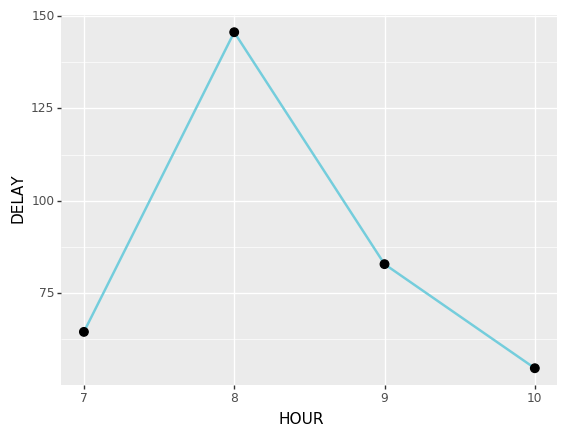

<ggplot: (-9223371920498882172)>

In [153]:
avg_delay_day = after_covid.groupby(['HOUR'])[['DELAY']].mean()
avg_delay_day = avg_delay_day.reset_index()

plot_delay_day = ggplot(avg_delay_day, aes(x='HOUR', y='DELAY')) + \
                    geom_line(color='#74CDDC',size=1) + \
                    geom_point(size=3) + \
                    scale_x_continuous(breaks=range(6, 13), minor_breaks=[]) + \
                    xlab("HOUR") + \
                    ylab("DELAY")
plot_delay_day

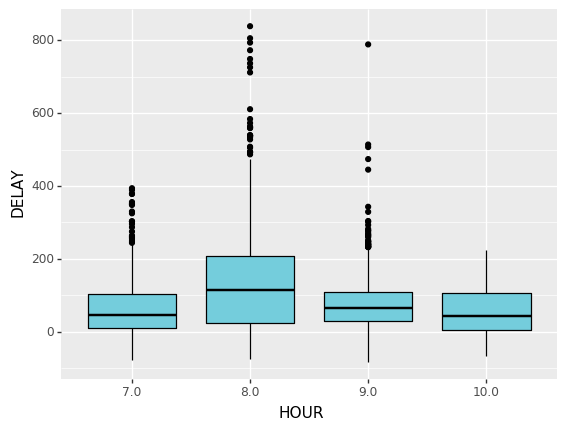

<ggplot: (-9223371920500801936)>

In [154]:
after_covid['HOUR_cat'] = after_covid['HOUR'].astype('category')

plotbox_delay_day = ggplot(after_covid, aes(x='HOUR_cat', y='DELAY')) + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("HOUR") + \
            ylab("DELAY")
plotbox_delay_day

In [155]:
after_covid.groupby('HOUR')['DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
HOUR,,,,,,,,
7.0,555.0,64.556757,82.749338,-78.0,10.50,46.0,103.5,394.0
8.0,572.0,145.594406,155.127832,-74.0,24.75,115.0,209.0,839.0
9.0,437.0,82.874142,91.319558,-84.0,29.00,64.0,109.0,789.0
10.0,116.0,54.732759,65.280047,-68.0,3.75,42.0,106.0,224.0


### **Nějvětší zpoždění kolem 8. hodiny -> upravení datasetu pouze na tento úsek**

In [158]:
t1 = dt.time(7,30,0)
t2 = dt.time(9,0,0)

In [159]:
bebe = after_covid[ (after_covid['ORIGIN_TIMESTAMP']>=t1) & (after_covid['ORIGIN_TIMESTAMP']<=t2) ]

In [184]:
# populace = statisticke udaje pro veskere hodnoty Actual Delay
bebe['DELAY'].describe()

count    887.000000
mean     121.615558
std      139.674557
min      -74.000000
25%       22.000000
50%       82.000000
75%      189.000000
max      839.000000
Name: DELAY, dtype: float64

## **Zkouška normality rozdělení**

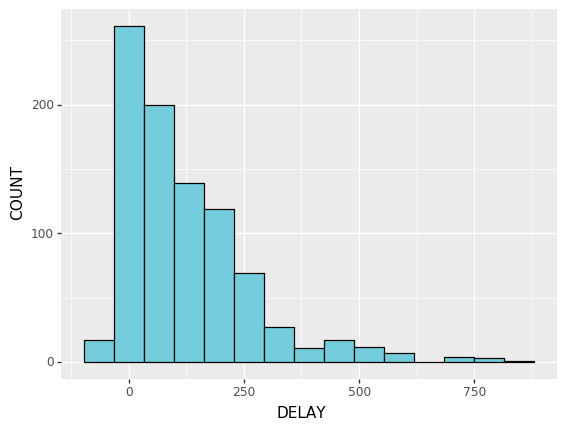

<ggplot: (-9223371920497591640)>

In [166]:
# histogram
plot_hist1 = ggplot(bebe, aes(x='DELAY')) + \
            geom_histogram(color='black', fill='#74CDDC', bins=15) + \
            xlab("DELAY") + \
            ylab("COUNT")

plot_hist1

In [167]:
# normality test
stat, p = shapiro(bebe['DIFF_DELAY'])
print(f'Statistics={stat}, p={round(p,5)}')

alpha = 0.1
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.8699530363082886, p=0.0
Sample does not look Gaussian (reject H0)


## **Grafy závislosti zpoždění na zastávkách**

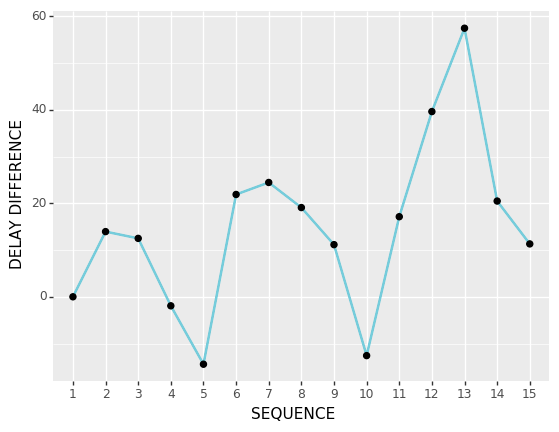

<ggplot: (-9223371920494059512)>

In [182]:
avg_delay_for_stop = bebe.groupby(['SEQUENCE'])[['DIFF_DELAY']].mean()
avg_delay_for_stop = avg_delay_for_stop.reset_index()

plot_poin_delay_stop = ggplot(avg_delay_for_stop, aes(x='SEQUENCE', y='DIFF_DELAY')) + \
    geom_point() + \
    geom_line() + \
    geom_line(color='#74CDDC',size=1) + \
    geom_point(size=2) + \
    scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)) + \
    xlab("SEQUENCE") + \
    ylab("DELAY DIFFERENCE")
plot_poin_delay_stop

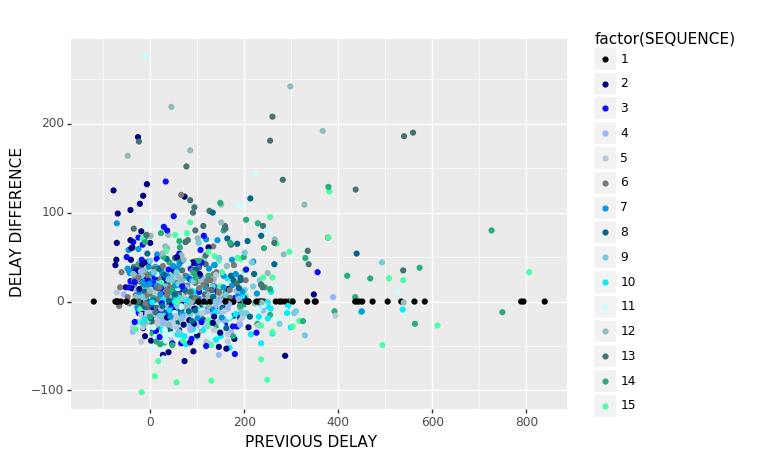

<ggplot: (-9223371920496516464)>

In [144]:
# zavislost zpozdeni z predchozi zastavky na rozdilu ve zpozdeni na urovni vsech zastavek 
plot_point1 = ggplot(bebe,(aes(x='PREV_DELAY', y='DIFF_DELAY',color = 'factor(SEQUENCE)'))) + \
        scale_color_manual(values=color) + \
        geom_point() + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point1

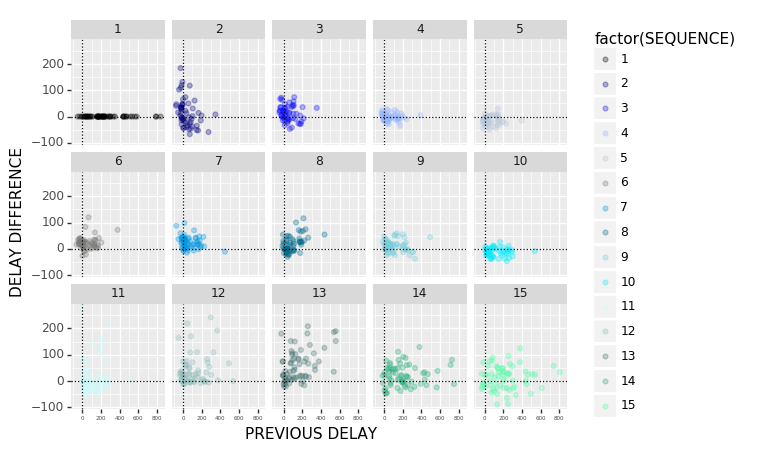

<ggplot: (-9223371920497435828)>

In [169]:
# zavislost zpozdeni z predchozi zastavky na rozdilu ve zpozdeni na urovni jednotlivych zastavek 
plot_point2 = ggplot(bebe, aes(x='PREV_DELAY', y='DIFF_DELAY', color = 'factor(SEQUENCE)' )) + \
        geom_point(alpha=0.3) + \
        geom_hline(yintercept=0,linetype='dotted') + \
        geom_vline(xintercept=0,linetype='dotted') + \
        theme(axis_text_x = element_text(size=4)) + \
        facet_wrap(['SEQUENCE'], nrow=3) + \
        scale_color_manual(values=color) + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point2

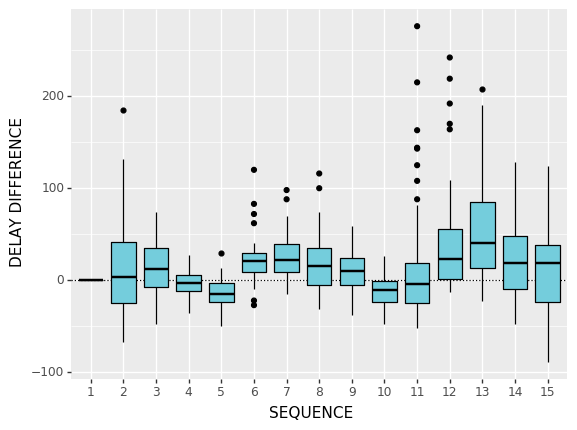

<ggplot: (-9223371920496751364)>

In [178]:
# boxplot rozdilu zpozdeni na jednotlive zastavky 
# a boxplot of the arrival difference for each bus stop, what this plot shows the spread of the delays with some outliers
bebe['SEQUENCE_cat'] = bebe['SEQUENCE'].astype('category')

plot_box1 = ggplot(bebe, aes(x='SEQUENCE_cat', y='DIFF_DELAY')) + \
            geom_hline(yintercept=0,linetype='dotted') + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("SEQUENCE") + \
            ylab("DELAY DIFFERENCE")
plot_box1

In [186]:
bebe.groupby('SEQUENCE')['DIFF_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
SEQUENCE,,,,,,,,
1,57.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
2,56.0,13.946429,53.296911,-67.0,-24.50,4.0,41.75,185.0
3,56.0,12.500000,29.430967,-47.0,-7.50,12.0,35.25,74.0
4,56.0,-1.928571,13.764060,-35.0,-11.50,-3.0,5.50,28.0
5,55.0,-14.418182,16.315967,-50.0,-23.50,-15.0,-2.50,30.0
6,55.0,21.890909,23.606867,-27.0,9.50,21.0,30.00,120.0
7,61.0,24.459016,22.537061,-15.0,9.00,22.0,39.00,98.0
8,56.0,19.089286,31.411797,-31.0,-4.75,16.0,35.25,116.0
9,57.0,11.157895,22.415547,-38.0,-5.00,10.0,24.00,59.0


In [188]:
bebe[bebe['SEQUENCE']!=13]['DIFF_DELAY'].describe()

count    821.000000
mean      12.092570
std       38.841406
min      -89.000000
25%      -10.000000
50%        3.000000
75%       28.000000
max      276.000000
Name: DIFF_DELAY, dtype: float64

In [190]:
bebe[bebe['SEQUENCE']==13]['DIFF_DELAY'].describe()

count     66.000000
mean      57.454545
std       59.487085
min      -22.000000
25%       13.250000
50%       40.000000
75%       85.000000
max      208.000000
Name: DIFF_DELAY, dtype: float64

## **Grafy závislosti zpoždění na dnech**

In [199]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
bebe['DAY_OF_WEEK'] = pd.Categorical(bebe['DAY_OF_WEEK'], days)
bebe.sort_values('DAY_OF_WEEK')

,TRIP_ID,ROUTE,DAY_OF_WEEK,DATE,UNICORN,START_TIME,HEADSIGN,STOP_ID,STOP_SEQUENCE,STOP_NAME,...,DELAY,ORIGIN_TIMESTAMP,TIMETABLE_ARRIVAL_TIME,DIFF_DELAY,PREV_DELAY,SEQUENCE,HOUR,HOUR_cat,SEQUENCE_cat,DAY_OF_WEEK_cat
4656,333_751_200302,333,Monday,2020-05-18,333_751_200302_18_May,08:48:00,"Praha,Kačerov",U783Z2,8,U Libušské sokolovny,...,44.0,08:59:45,08:59:00,20.0,24.0,7,8.0,8.0,7,Monday
4644,333_1094_200302,333,Monday,2020-05-18,333_1094_200302_18_May,08:15:00,"Praha,Kačerov",U194Z2,23,Jalodvorská,...,206.0,08:52:16,08:49:00,-11.0,217.0,10,8.0,8.0,10,Monday
4643,333_1094_200302,333,Monday,2020-05-18,333_1094_200302_18_May,08:15:00,"Praha,Kačerov",U804Z2,22,U Zvoničky,...,217.0,08:51:37,08:48:00,9.0,208.0,9,8.0,8.0,9,Monday
4642,333_1094_200302,333,Monday,2020-05-18,333_1094_200302_18_May,08:15:00,"Praha,Kačerov",U335Z2,21,Libuš,...,208.0,08:50:30,08:47:00,39.0,169.0,8,8.0,8.0,8,Monday
4641,333_1094_200302,333,Monday,2020-05-18,333_1094_200302_18_May,08:15:00,"Praha,Kačerov",U783Z2,20,U Libušské sokolovny,...,169.0,08:48:46,08:46:00,23.0,146.0,7,8.0,8.0,7,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,333_1064_200302,333,Friday,2020-05-22,333_1064_200302_22_May,06:59:00,"Praha,Kačerov",U656Z2,25,Sídliště Krč,...,36.0,07:36:24,07:36:00,9.0,27.0,12,7.0,7.0,12,Friday
3400,333_1064_200302,333,Friday,2020-05-22,333_1064_200302_22_May,06:59:00,"Praha,Kačerov",U749Z2,24,Tempo,...,27.0,07:35:23,07:35:00,-27.0,54.0,11,7.0,7.0,11,Friday
3399,333_1064_200302,333,Friday,2020-05-22,333_1064_200302_22_May,06:59:00,"Praha,Kačerov",U194Z2,23,Jalodvorská,...,54.0,07:34:13,07:33:00,-32.0,86.0,10,7.0,7.0,10,Friday
3411,333_1115_200302,333,Friday,2020-05-22,333_1115_200302_22_May,07:12:00,"Praha,Kačerov",U783Z2,18,U Libušské sokolovny,...,42.0,07:40:41,07:40:00,1.0,41.0,7,7.0,7.0,7,Friday


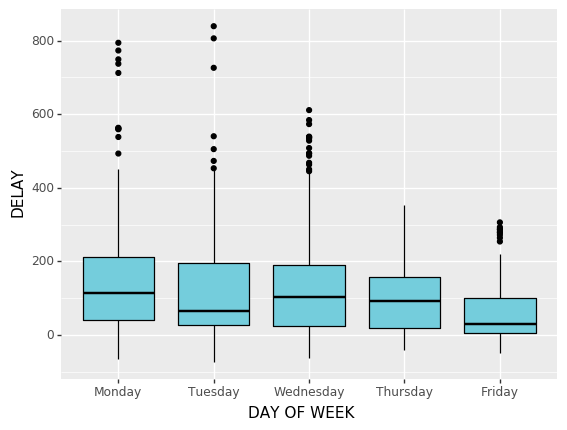

<ggplot: (-9223371920496480940)>

In [204]:
# boxplot zpozdeni v zavislosti na dni v tydnu
bebe['DAY_OF_WEEK_cat'] = bebe['DAY_OF_WEEK'].astype('category')

plot_box2 = ggplot(bebe, aes(x='DAY_OF_WEEK_cat', y='DELAY')) + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("DAY OF WEEK") + \
            ylab("DELAY")
plot_box2

In [201]:
days_col = ['#74CDDC' , '#ffffb3','#BBC9DB','#fb8072','#386cb0','#28AE7B','#4DFFA5']

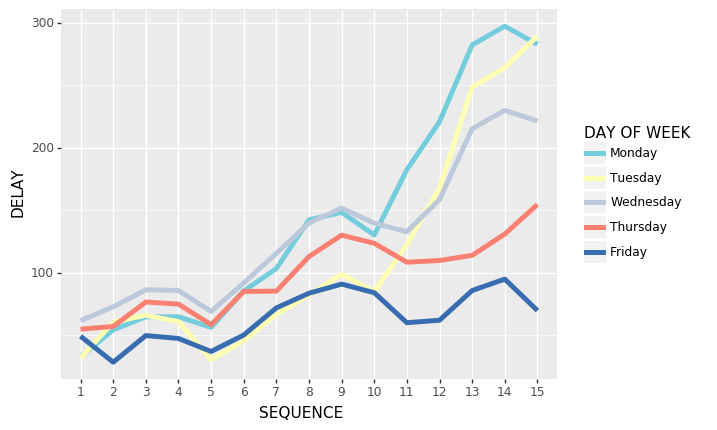

<ggplot: (-9223371920499646096)>


In [203]:
avg_delay_per_day_stop = bebe.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DELAY']].mean()
avg_delay_per_day_stop = avg_delay_per_day_stop.reset_index()
plot_week1 = ggplot(avg_delay_per_day_stop, aes(x='SEQUENCE', y='DELAY', color='DAY_OF_WEEK')) +\
            geom_line(size=2) + \
            xlab("SEQUENCE") + \
            ylab("DELAY") + \
            labs(color='DAY OF WEEK') + \
            scale_color_manual(values=days_col) + \
            scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))
print(plot_week1)

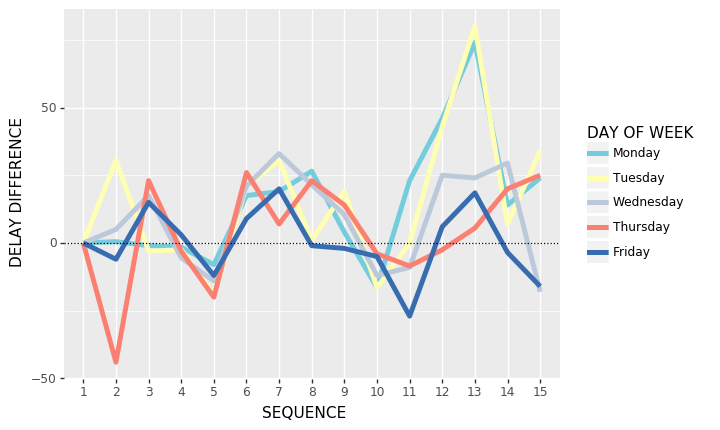

<ggplot: (-9223371920497190488)>


In [205]:
avg_diff_per_day_stop = bebe.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DIFF_DELAY']].median()
avg_diff_per_day_stop = avg_diff_per_day_stop.reset_index()
plot_week2 = ggplot(avg_diff_per_day_stop, aes(x='SEQUENCE', y='DIFF_DELAY', color='DAY_OF_WEEK')) +\
            geom_line(size=2) + \
            xlab("SEQUENCE") + \
            ylab("DELAY DIFFERENCE") + \
            geom_hline(yintercept=0,linetype='dotted') + \
            labs(color='DAY OF WEEK') + \
            scale_color_manual(values=days_col) + \
            scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))    
print(plot_week2)